In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys,os, re
import pandas as pd
from functools import partial
import itertools
import json, glob

    
repobase="/Users/rosamartinezcorral/OneDrive - CRG - Centre de Regulacio Genomica/papers/github_repos/MPRAfitting/"
sys.path.append(os.path.join(repobase,"bin"))
from functions_fractional_occupancy import fi_1sites, fi_2sites, fi_3sites, fi_4sites, fi_5sites, fi_6sites
from biophysmodel_utils import logfoldchange_from_avbinding_ratesdirectly_Hill, get_S_max
from utils_fit import run_genetic, get_parsetnames, get_meanabserrorperaffinity_avbinding, error_parset_avbinding_celltypedifbyx
from utils_fit import dataframe_from_bestpars
evaluate_parset_function=get_meanabserrorperaffinity_avbinding
fifunctions={1:fi_1sites, 2:fi_2sites, 3:fi_3sites,4:fi_4sites,5:fi_5sites,6:fi_6sites}

In [4]:
def plot_best(best,args_fitnessfunction,afcats=None):
    afcats=affinities_tofit
    #best is the parameter set to be plotted
    ncol=len(afcats) #categories of affinities fitted
    out=dataframe_from_bestpars(parset,**args_fitnessfunction)
    #display(out)
    fig,axes=plt.subplots(1,ncol,figsize=(15,4),sharey=True)
    df_data_and_model=out[0] #if there would be more conditions, we would have more in out
    df_data_and_model["afcat"]=df_data_and_model["afcat"].apply(lambda x:"%2.2f"%x)
    colors=["blue","cyan","lightgreen","orange","red","purple"]
    for a,afcat in enumerate(afcats):
        subdf=df_data_and_model[df_data_and_model["afcat"]==afcat]
        
        print(afcat, subdf["afcat"].unique())
        xvals=subdf["nrepeats"]
        yvals=subdf["meandata"]
        ymodelvals=subdf["model"]
        ax=axes[a]
        color=colors[a]
        ax.scatter(xvals, yvals,c=color)
        ax.plot(xvals,ymodelvals,color=color)
        ax.set_xlabel("nrepeats")
        ax.set_ylabel("log fold change")
    plt.tight_layout()
    plt.show()

In [5]:
#load the data
TF="Sp1"
data=pd.read_csv("./expdata/MPRA/SuppData_withAf.csv")
data
data

,Unnamed: 0,ID,Sequence,nrepeats,Affinity group,Mean binding site affinity,Sum of binding site affinities,Spacing between sites,Orientation of sites,Replicate 1,Replicate 2,Mean,affinity_site_1,affinity_site_2,affinity_site_3,affinity_site_4,affinity_site_5,affinity_site_6
0,0,Sp1.1,aggaccggatcaactgaatttgaaattacgttccaggcgtcggagt...,1,1.00,12.527789,12.527789,4,fwd,0.073337,-0.040363,0.018847,12.527789,NaN,NaN,NaN,NaN,NaN
1,1,Sp1.2,aggaccggatcaactgctccgcggcttttggtaaaaataattcgac...,1,1.00,12.527789,12.527789,10,fwd,0.073805,0.147987,0.113257,12.527789,NaN,NaN,NaN,NaN,NaN
2,2,Sp1.3,aggaccggatcaactcgacgaaggccggcaaatagttcatgggacc...,1,1.00,12.527789,12.527789,20,fwd,-0.102820,-0.169324,-0.133712,12.527789,NaN,NaN,NaN,NaN,NaN
3,3,Sp1.4,aggaccggatcaactgtaagtgctgtcctacactgacagtgtgact...,1,1.00,12.527789,12.527789,4,rev,0.357273,0.246388,0.304191,12.527789,NaN,NaN,NaN,NaN,NaN
4,4,Sp1.5,aggaccggatcaactgggcgctactgcgtcgatttaagtaatgaca...,1,1.00,12.527789,12.527789,10,rev,-0.294836,-0.286001,-0.288058,12.527789,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191,Sp1.192,aggaccggatcaactcagtcccggggaatgcatgaagttcgctccc...,6,0.25,6.965672,41.794034,10,tandem,-0.040295,-0.175021,-0.105298,6.901010,7.058295,7.061587,6.937236,6.847482,6.988424
192,192,Sp1.193,aggaccggatcaactttccctcatcgtagatcgactttaccgctgt...,6,0.25,6.857200,41.143202,20,tandem,-0.388067,-0.502576,-0.442961,6.711255,7.058295,7.076221,6.746556,6.933641,6.617232
193,193,Sp1.194,aggaccggatcaactgttacatacccgaatcgccagagtaatcatg...,6,0.10,4.673462,28.040772,4,tandem,0.358360,0.207757,0.285419,4.413828,5.007064,4.582120,4.669917,4.549503,4.818339
194,194,Sp1.195,aggaccggatcaactattcggcaagagtgccggttagaggaccatc...,6,0.10,4.784906,28.709437,10,tandem,0.239904,0.223515,0.234070,4.984908,4.904738,4.426321,4.787191,5.072549,4.533729


In [6]:
data["afcat"]=data["Affinity group"].apply(lambda x:"%2.2f"%x)
data["afcat"].unique()

array(['1.00', '0.89', '0.75', '0.50', '0.25', '0.10'], dtype=object)

In [12]:

df_TF=data
affinitygrouping="afcat"
affinities_tofit=["1.00", "0.75", "0.10"]
jid=1
#3 seeds take about 3-5 min. 

#prepare the data for the fit
columns_input=["affinity_site_1","affinity_site_2","affinity_site_3","affinity_site_4","affinity_site_5","affinity_site_6"]
col_toplot=affinitygrouping
columns1=["Mean","affinity_site_1","affinity_site_2","affinity_site_3","affinity_site_4","affinity_site_5","affinity_site_6"]

meandata=df_TF.groupby([affinitygrouping,"nrepeats"])[columns1].apply(lambda x:x.mean()).reset_index() #average over orientation and spacing
print("head of meandata")
display(meandata.head(n=6))

#this code had previously been used to fit multiple cell types or conditions assumed to differ in concentration.
#adapting here to just fit one cell type

inputs_outputs=[]

data_condition=[]
clusterID=0 #here only K562 cells
celltype="K562"
for nrepeats in [1,2,3,4,5,6]:

    mean=meandata[(meandata["nrepeats"]==nrepeats)&(meandata["afcat"].isin(affinities_tofit))]
    #display(mean.head(n=2))
    input_=mean[columns_input[0:nrepeats]].values
    output_=mean["Mean"].values
    input_toplot=mean[col_toplot].values
    condition=["av","av",nrepeats,clusterID] #orientation,spacer,nrepeats,celltype
    data_condition.append([input_,output_,input_toplot,condition])
    #ar=np.hstack((input_,output_.reshape(3,1),input_toplot.reshape(3,1)))
    #np.savetxt(os.path.join(outfolder,"average3affcat_%s_%d.txt"%(TF,nrepeats)),ar)
inputs_outputs.append(data_condition)

head of meandata


,afcat,nrepeats,Mean,affinity_site_1,affinity_site_2,affinity_site_3,affinity_site_4,affinity_site_5,affinity_site_6
0,0.10,1,-0.253672,4.798302,NaN,NaN,NaN,NaN,NaN
1,0.10,2,-0.135256,4.744986,4.958213,NaN,NaN,NaN,NaN
2,0.10,3,0.040967,4.577369,4.802075,4.658180,NaN,NaN,NaN
3,0.10,4,-0.017886,4.664960,4.639647,4.799687,4.767206,NaN,NaN
4,0.10,5,0.106125,4.886390,4.740787,4.729902,4.847214,4.853996,NaN
5,0.10,6,0.179130,4.540281,4.732273,4.687118,4.744692,4.737489,4.579196


bounds: [[-7, 7], [-1, 1], [-7, 7], [-7, 7], [-7, 7], [-7, 7], [-7, 7], [-3, 3], [-7, 7], [-7, 7], [-3, 3], [-7, 7], [-7, 7], [-3, 3], [-7, 7], [-7, 7], [-3, 3], [-7, 7]]
('K_max', [-7, 7])
('lambda_K', [-1, 1])
('k_1', [-7, 7])
('k_m1', [-7, 7])
('k_2', [-7, 7])
('k_3', [-7, 7])
('K_r0', [-7, 7])
('n_r0', [-3, 3])
('fc_r0', [-7, 7])
('K_r1', [-7, 7])
('n_r1', [-3, 3])
('fc_r1', [-7, 7])
('K_r2', [-7, 7])
('n_r2', [-3, 3])
('fc_r2', [-7, 7])
('K_r3', [-7, 7])
('n_r3', [-3, 3])
('fc_r3', [-7, 7])
seed 0


/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Initial fitness values: [0.2070766359647445, 0.19791317548369095, 0.19791317548369095, 0.18767229727822468, 0.18767229727822468, 0.18767229727822468, 0.18767229727822468, 0.18767229727822468, 0.18176613288675766, 0.18176613288675766]
Final fitness values: [0.16641883084881828, 0.16641883084881828, 0.1664187896307619, 0.16548739814543234, 0.16581629172949439, 0.16579607018872647, 0.16487658743615285, 0.16487658743615285, 0.16464275916029456, 0.16487658743615285]


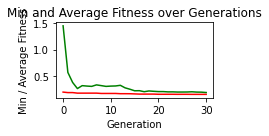

HOF ITEM
0.16464275916029456
-0.7225919731918461,-0.23044864408588195,-5.430134796042371,-5.406685227669998,-5.919269035943715,3.5970945516947666,-3.5211596857621723,2.6899266765878433,1.334036110294261,-1.598408423604557,0.29275593636669633,2.031939470003241,4.329581291288749,0.005675226952440604,-1.6647892948291456,-6.050018552147144,1.65576283407976,5.7068383152463165
HOF ITEM
0.16487658743615285
-0.7225919731918461,-0.23044864408588195,-5.430134796042371,-5.406685227669998,-5.919269035943715,3.5970945516947666,-3.5211596857621723,2.6899266765878433,1.334036110294261,-1.598408423604557,0.29275593636669633,2.031939470003241,6.173304618293937,-0.3714722909218543,-1.705663775034482,-6.050018552147144,-0.29854787865936605,5.452920341589225
HOF ITEM
0.16487666348495597
-0.7225919731918461,-0.23044864408588195,-5.430134796042371,-5.406685227669998,-5.919269035943715,3.5970945516947666,-3.5211596857621723,2.6899266765878433,1.334036110294261,-1.598408423604557,0.29275593636669633,2.0319394

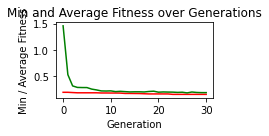

HOF ITEM
0.1594892671827552
-0.18963343265997512,-0.30254646090470816,2.0525915082400124,0.6215617100549173,-6.8133223557455835,1.236659964664777,-3.2100466649969017,-0.7211462132279154,-6.73586323434174,-2.749474454711603,2.668034475763523,-4.852106823726228,0.7299433057487401,0.4088383061531544,-2.2090110918888075,-2.0913593497026493,2.7546721051152137,0.7468152924332898
HOF ITEM
0.1595781492185541
-0.18963343265997512,-0.30254646090470816,2.0525915082400124,0.6215617100549173,-6.8133223557455835,1.236659964664777,-3.2100466649969017,-0.7211462132279154,-7.0,-2.749474454711603,2.668034475763523,-4.852106823726228,0.7299433057487401,0.4088383061531544,-2.1921186964785884,-2.0913593497026493,2.7546721051152137,0.7468152924332898
HOF ITEM
0.15999875602671307
-0.6875028089902002,-0.30254646090470816,2.0525915082400124,0.6215617100549173,-6.8133223557455835,2.674512916560465,-3.8197645801059155,-0.05795940310455283,-6.950240043356046,-2.749474454711603,2.336090443553684,-4.852106823726228

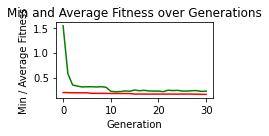

HOF ITEM
0.1625960605332337
2.4183418504869043,1.0,1.9349877483153222,6.410242489919134,5.364227316150119,-1.4036139832049639,5.584968637545795,0.7485089959804346,3.873569049111865,1.7743033696241908,1.952857559766466,3.7618058378934105,5.6678390973286605,-1.8785586669295653,0.2050123820211727,4.0939879018703635,0.86756988690267,5.984629083100496
HOF ITEM
0.1634783476038669
2.3974696493172827,0.7582524770319805,0.9304155588303104,5.418354310413537,5.364227316150119,-1.4036139832049639,5.464274334795514,0.7485089959804346,4.272991005459072,1.7743033696241908,1.5198042837447443,3.7618058378934105,5.6678390973286605,-1.8785586669295653,0.1946283561660691,3.761185639260004,0.86756988690267,5.984629083100496
HOF ITEM
0.1655605640399031
2.3974696493172827,0.7582524770319805,0.8979662805867595,5.418354310413537,5.364227316150119,-1.4036139832049639,5.464274334795514,-0.27054103110280747,2.2508132224776665,1.7743033696241908,1.952857559766466,3.7618058378934105,5.6678390973286605,-1.8785586669

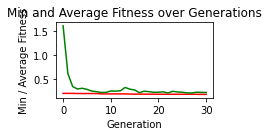

HOF ITEM
0.1773698788839999
2.0433688208213834,1.0,-4.461667945439954,-2.2827700363369967,-4.219018169656759,2.5686107303762356,1.657651158433524,1.9133258459605462,-6.209161898351501,3.5221291632248217,-0.08173705767554185,-2.4010941806574664,7.0,-0.383725155181866,-3.584472522584022,-7.0,2.9602513332569393,4.014553780193045
HOF ITEM
0.17791187832539943
2.0433688208213834,1.0,-4.461667945439954,-2.2827700363369967,-4.219018169656759,2.5686107303762356,1.657651158433524,1.9133258459605462,-6.209161898351501,3.5221291632248217,0.15305457689139212,-1.812291544959485,6.288301045733794,0.2797118887879032,-2.5848713936774397,-7.0,2.9602513332569393,4.014553780193045
HOF ITEM
0.17944508617157326
1.8225179213545901,1.0,-6.9618208578791325,-1.516518665169272,-3.457410534644916,2.442372423384984,1.657651158433524,1.9133258459605462,-6.209161898351501,3.9018443806823013,0.15305457689139212,-1.812291544959485,6.288301045733794,0.2797118887879032,-2.5848713936774397,-7.0,2.9602513332569393,4.01455

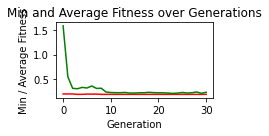

HOF ITEM
0.19003767864396204
-5.966770366638595,-0.06945742017479584,-6.482752482409793,-3.5199891672360923,7.0,5.237360751139889,-4.148610690493872,1.991879106918803,-5.695998778613645,-2.157805536309621,1.812246421234528,-4.625032909043706,-5.99438908784707,-3.0,1.7216465335524347,3.030324376013534,2.8888591526233522,1.7193284168664904
HOF ITEM
0.19003909102145947
-5.966770366638595,0.6359220235237508,-7.0,-3.164099763538019,6.0483749774717435,6.230806451118381,-4.148610690493872,1.991879106918803,-5.73539893385963,-0.34164934113243484,1.812246421234528,-5.570285704121498,-5.99438908784707,-3.0,1.7216465335524347,2.7198671449707414,2.8888591526233522,3.0200757263922293
HOF ITEM
0.19003932898788303
-5.966770366638595,1.0,-7.0,-3.5199891672360923,4.281343389129952,5.237360751139889,-4.148610690493872,1.991879106918803,-5.695998778613645,-2.157805536309621,0.796726274696921,-2.234032011608692,0.796472154349978,0.5028422512338202,-6.363106597701721,3.030324376013534,2.8888591526233522,2.

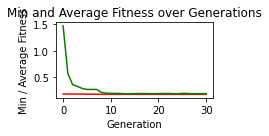

HOF ITEM
0.1812511690722295
-4.446161427093642,0.5001438373885012,3.343757773972858,2.0022735516771344,-1.838041364247796,5.791055194524608,-0.3200324671178897,0.5445289514784574,-3.4661967839371677,-6.867839979416701,2.3867607886305433,1.5939884282811692,5.06261378931756,-0.47200026349832935,0.8987129474967941,-3.3977193419441782,-0.24376625502679494,2.4280004607387973
HOF ITEM
0.18130978475136306
-4.446161427093642,0.7351501633250145,3.343757773972858,2.0022735516771344,-1.838041364247796,5.45681384917339,-0.45159179239292857,0.7640706402341827,-3.005378398939845,-6.867839979416701,2.3917439381563184,1.5939884282811692,5.06261378931756,-0.47200026349832935,1.167367995455183,-4.911456346153416,1.292543697113276,0.8818431620927663
HOF ITEM
0.1813448750238428
-4.446161427093642,-0.03283757178111513,3.343757773972858,2.0022735516771344,-1.1394306787936246,3.349545323446457,-0.3200324671178897,0.7640706402341827,-3.005378398939845,-5.8083408942571,2.3917439381563184,1.5939884282811692,6.0

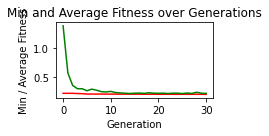

HOF ITEM
0.19062220328546273
-0.14760690723543415,1.0,7.0,-6.377722080303579,-5.714027530928951,-1.1445436980245243,-0.81677794723285,-1.9793533805717267,1.9547780212174863,-4.285556802457819,2.607495379829326,-2.050783480718664,1.052715752073921,1.816145693835502,-7.0,-5.698250455830574,-2.1519789286739264,0.5842096775736703
HOF ITEM
0.19187430717990375
-0.18422605378587542,1.0,7.0,-3.579909997866218,-5.710431943503928,-0.10732111219278728,-3.9590198636347322,-3.0,-5.457881129907957,-2.243707889170204,3.0,-1.4332420754990476,1.052715752073921,1.5941179148012719,-7.0,-5.4376516446651735,-2.3694633822189557,0.5842096775736703
HOF ITEM
0.1918786272802291
-0.18422605378587542,1.0,7.0,-3.579909997866218,-5.710431943503928,-0.19058114820683525,-3.329142299013652,-2.977909567251225,0.6873498532442609,-2.243707889170204,3.0,-1.4332420754990476,1.052715752073921,1.5941179148012719,-7.0,-5.4376516446651735,-2.3694633822189557,0.5842096775736703
seed 7
Initial fitness values: [0.2160225061388853

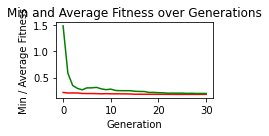

HOF ITEM
0.17954751418327897
-3.774867715809952,-0.897026596880983,-6.658423769448012,-1.5939799575299227,0.025109034599989477,4.275623623607649,6.406806659517015,-2.059483885676413,-0.8089623957303014,-5.450789601207609,2.598714368900932,3.3336838243878626,-4.470337672950219,-0.39210330045960906,2.017217332067444,6.546685585127715,0.14377400151164754,-1.8466559691916626
HOF ITEM
0.17958027391605882
-3.774867715809952,-0.897026596880983,-5.743791825483316,-1.5939799575299227,0.025109034599989477,4.275623623607649,6.406806659517015,-2.059483885676413,-0.8089623957303014,-5.450789601207609,2.598714368900932,3.3336838243878626,-4.431863756258071,-0.39210330045960906,2.017217332067444,6.441314327685974,-2.535174520153709,-1.8466559691916626
HOF ITEM
0.17967171330323595
-3.774867715809952,-0.897026596880983,-5.743791825483316,-1.5939799575299227,0.025109034599989477,4.275623623607649,6.406806659517015,-2.059483885676413,-0.8089623957303014,-5.450789601207609,2.598714368900932,3.333683824387

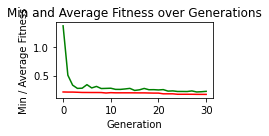

HOF ITEM
0.16458000571042386
2.0698173341461334,-0.12300903113869643,-5.4208932545442154,0.23311058989753763,4.935280382666315,-4.660057134493484,0.056844623787800364,2.655273179243533,1.599894362477094,3.6983259571234086,0.8305376373875333,-5.324953072313751,0.7892628684955065,-1.8472937352719767,2.3136706370144404,0.26214003722069346,0.20625616149640946,-2.938705175787062
HOF ITEM
0.1646420896826105
2.0698173341461334,-0.12300903113869643,-5.4208932545442154,0.23311058989753763,4.8132369581212675,-4.660057134493484,0.056844623787800364,2.655273179243533,1.599894362477094,2.1884555447201555,0.02810924134441073,-7.0,0.7892628684955065,-1.4930699643230032,2.3136706370144404,0.26214003722069346,0.20625616149640946,-2.938705175787062
HOF ITEM
0.16483106567564576
2.0698173341461334,-0.12300903113869643,-5.4208932545442154,-0.06021013474616804,4.785212601469283,-4.660057134493484,0.056844623787800364,2.943116551718871,2.42940970002269,2.1884555447201555,1.0202477369047283,-5.281409983970397

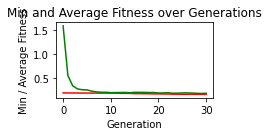

HOF ITEM
0.1695548319168669
2.4045682462319844,0.975066364135828,-3.358142432710075,3.0020474810061524,2.3684060000692635,-5.6512204480191714,2.850120097923712,-0.5516440948021588,-0.995129876352514,0.30954187136630074,1.3525531001082567,-5.065282349315128,1.879049640190491,-0.642534584768076,-1.477933798710301,1.6227702392990833,2.069268896709511,-1.3695067838968982
HOF ITEM
0.17064462840643016
2.4045682462319844,1.0,-3.1933115457128896,2.9346943079312857,1.9721589222575333,-5.807653344040062,2.157914414610797,0.7667953110812608,-1.8398930652354473,0.2533775359161787,1.4053472433060108,-2.606769977017929,1.879049640190491,-0.17446846837807806,-1.7501120269949837,1.6227702392990833,2.069268896709511,-1.3695067838968982
HOF ITEM
0.1710254556498785
2.4045682462319844,1.0,-3.811024428094631,2.0439003885288924,1.9624968392418887,-5.807653344040062,2.850120097923712,1.1560905821506862,-2.8719020616812108,0.30954187136630074,1.3525531001082567,-4.6950325570165585,2.3504702339625747,0.2114485

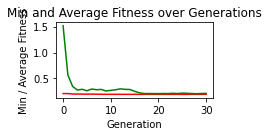

HOF ITEM
0.1915908203351615
-5.493707652320519,-1.0,-0.1378385148459218,1.5067978952957723,5.384376419866463,0.16654060491825512,0.6502922042431744,0.6652338962399121,-1.4768443242406009,-3.732045365412368,-2.273366154337988,-5.447870080408125,-4.412559144549737,1.9030755975970532,-6.602995106245187,2.736434890421246,2.578375710113607,4.6070584807089965
HOF ITEM
0.19159423992195412
-5.493707652320519,-1.0,-0.1378385148459218,1.5067978952957723,5.384376419866463,0.16654060491825512,0.6502922042431744,1.249387403398034,-0.6485763584349531,-3.732045365412368,-2.273366154337988,-5.447870080408125,-4.412559144549737,1.9030755975970532,-6.602995106245187,2.736434890421246,2.578375710113607,4.6070584807089965
HOF ITEM
0.19159762357477353
-5.493707652320519,-1.0,-0.1378385148459218,1.5067978952957723,5.384376419866463,0.16654060491825512,0.6502922042431744,0.10807054940676952,-0.6485763584349531,-3.732045365412368,-1.7258923366513927,-6.054561360895088,-4.412559144549737,1.9030755975970532,-6.

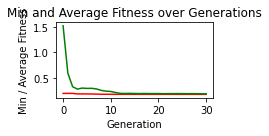

HOF ITEM
0.18088714878717094
-6.2756343484777295,-1.0,2.8559927181493183,-0.13993961262139165,-3.969292865497684,0.5035836079652629,2.6531751053304875,-0.7942341777762967,-2.906879661212698,3.8837818192401308,-2.774870454175783,-1.6563457858218293,0.5493417027657002,2.0710649139550683,-4.092634868140085,-7.0,1.9389759150931913,-4.34178301858223
HOF ITEM
0.18091416183803022
-6.2756343484777295,-1.0,2.8559927181493183,-0.13993961262139165,-3.969292865497684,0.5035836079652629,3.4582474325689843,-1.7710800254927113,-2.906879661212698,3.8837818192401308,-3.0,-7.0,0.10972746865342364,2.0710649139550683,-4.350451006186562,-7.0,1.9389759150931913,-4.34178301858223
HOF ITEM
0.18092524857536105
-6.2756343484777295,1.0,2.8559927181493183,-0.13993961262139165,-3.969292865497684,0.5035836079652629,3.752722599238655,-1.7710800254927113,-1.1858602715703817,3.8837818192401308,-2.774870454175783,-6.766983508801358,-0.3533520795099052,2.0710649139550683,-4.092634868140085,-7.0,1.9389759150931913,-4.341

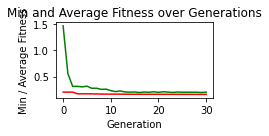

HOF ITEM
0.16049708405166355
0.12435612230745074,-0.24945362271448523,1.1228573079479764,2.68824663669464,6.699417839551013,1.7015347332511404,-1.64206229491366,3.0,4.517564552767187,-1.5987560469008404,0.8543102990353209,6.784947978868114,7.0,-2.960882382389099,4.8433723885348545,-1.9252641253064378,-0.6162803102727255,-2.8775649563131926
HOF ITEM
0.16087358094568774
0.12435612230745074,-0.24945362271448523,1.1228573079479764,1.3233566075807817,5.459490647822916,1.7015347332511404,-2.6109477504219143,3.0,4.517564552767187,-1.5987560469008404,-0.03046235031884112,6.983065724244947,7.0,-2.960882382389099,4.8433723885348545,-1.9252641253064378,-0.6162803102727255,-2.8775649563131926
HOF ITEM
0.160934262150069
0.12435612230745074,-0.24945362271448523,1.1228573079479764,2.68824663669464,6.699417839551013,1.7015347332511404,-3.093209775179713,3.0,4.517564552767187,-1.5987560469008404,-0.03046235031884112,6.983065724244947,7.0,-2.960882382389099,4.8433723885348545,-1.9252641253064378,-0.6162

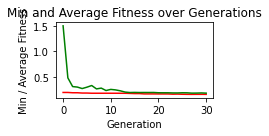

HOF ITEM
0.1620872740657959
0.7203535914404535,0.71395500800878,0.8891203777438815,-4.865964568030094,2.1032630394979055,6.016198238936086,0.8327009265380593,3.0,-0.6199663037566316,-6.414182202904623,-2.730895367945982,-0.5636376765613033,2.587224233096687,0.7754388948016946,4.942390801541523,5.77571442741681,-0.4509829189196324,-4.6925980575095885
HOF ITEM
0.16233479466430953
0.7203535914404535,0.71395500800878,1.5528499756114456,-5.226833782852004,2.6491174500722683,6.016198238936086,0.8327009265380593,3.0,-0.6199663037566316,-6.493078275532351,-1.9582229993342914,-1.6360708430177235,2.587224233096687,0.7754388948016946,4.942390801541523,5.77571442741681,-0.7578375000990087,-5.789595305913459
HOF ITEM
0.16288666014042322
0.7203535914404535,0.71395500800878,1.5528499756114456,-5.226833782852004,2.6491174500722683,6.016198238936086,0.8327009265380593,3.0,-0.6199663037566316,-6.070437704710248,-2.730895367945982,-0.5636376765613033,2.587224233096687,0.7754388948016946,4.725255696275353

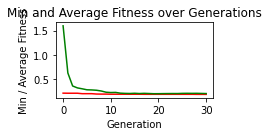

HOF ITEM
0.17857763275273164
-4.845387919954626,1.0,0.9079796130149849,-6.730448553938348,-0.24863439652526392,-1.4457418019563608,-4.742512836804858,2.2720828302068297,-2.6380930397460967,-3.363328520625362,2.4808688326736563,-5.12943953784281,1.444443447617699,-0.33117009781058854,2.614594910665494,-0.008326499033048052,-0.10122342483206576,0.41310843551428755
HOF ITEM
0.17860384629417772
-4.845387919954626,1.0,0.9079796130149849,-6.730448553938348,-0.24863439652526392,-1.4457418019563608,-4.742512836804858,2.2720828302068297,-2.6380930397460967,-3.9603841796568577,1.3994217989269262,-5.12943953784281,1.444443447617699,-0.33117009781058854,2.614594910665494,-0.008326499033048052,-0.10122342483206576,0.41310843551428755
HOF ITEM
0.17863396143261567
-4.727799166213533,1.0,0.9079796130149849,-6.730448553938348,-0.24863439652526392,-1.4457418019563608,-4.742512836804858,2.2720828302068297,-2.6380930397460967,-4.592000016606417,2.4808688326736563,-5.12943953784281,1.444443447617699,-0.331

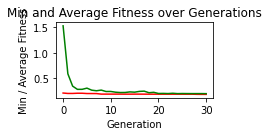

HOF ITEM
0.17790838230425407
-3.646341757252496,0.8164066330271376,3.5906148307203645,-0.9874468679793225,-0.982456125848334,-1.8744743883107786,-3.394394470780903,2.6889844371972984,-5.311034025543909,2.9061485296851077,3.0,5.080367286453369,-1.3042859737392833,1.7303570970053606,0.4639681297753575,0.4225395941514387,0.6684276135150973,4.113108792719672
HOF ITEM
0.17905584584107567
-3.646341757252496,-1.0,3.6854966846172115,-0.8927294619052109,-0.982456125848334,-1.8744743883107786,-3.394394470780903,2.6889844371972984,-5.311034025543909,2.9061485296851077,3.0,5.080367286453369,-1.3042859737392833,1.7303570970053606,0.4639681297753575,0.4225395941514387,0.6684276135150973,3.891541902741988
HOF ITEM
0.18116753296347954
-3.646341757252496,-1.0,3.6854966846172115,-1.1065693331223985,-1.6711575713351365,0.806711524600588,-3.2821639568573637,2.6889844371972984,-4.870565311403381,2.643015928497811,3.0,6.236547612802671,-0.5393534445452903,-0.02096417492430569,1.429163455141094,2.15644478595

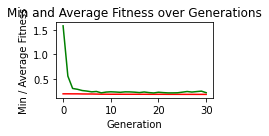

HOF ITEM
0.1887761012199691
-6.368719115002923,-1.0,0.31942752950899544,-0.8681086269814726,-1.0173522132564765,-1.9205256301529374,-5.1888055164778875,1.8221386523817737,5.659722012692373,-4.546199974481025,-1.300701482524316,-0.508433421757269,4.691773021392618,-0.2971594575019598,-2.6271003509246333,-4.655840777086231,1.7582299715538854,-5.629295850290129
HOF ITEM
0.18923993616393386
-6.368719115002923,-1.0,1.5428626471170408,0.608188405874299,0.513046951041142,-1.1576091632859198,-5.850357290846393,1.8221386523817737,5.659722012692373,-4.309183229413191,-1.300701482524316,-1.5717728092664842,4.691773021392618,-0.2971594575019598,-2.6271003509246333,-4.618236287112632,1.7582299715538854,-4.899315696126994
HOF ITEM
0.18924895658252494
-6.368719115002923,-1.0,1.4511087436555759,0.608188405874299,0.513046951041142,-1.1576091632859198,-5.1888055164778875,1.8221386523817737,3.9658503218995476,-5.432934086807295,-1.300701482524316,-1.5717728092664842,4.691773021392618,-0.2971594575019598,

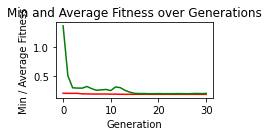

HOF ITEM
0.17982283309440358
3.093590604856805,0.3468584225478722,5.414791107924576,0.4255087334365549,-4.882810108569423,2.7005563776310852,2.573357005539348,0.9897942532354704,6.297946106703333,2.53778122742277,-0.7194259272913333,-3.3236667357671887,1.6479735605102706,2.2560434100940854,-0.9717869839041748,3.8686122285056315,0.7915805626299804,-2.338181010406874
HOF ITEM
0.17985394298982318
3.093590604856805,0.32389446889978,5.414791107924576,0.7435290687909368,-5.3859370858377815,2.2323617803585343,0.7659300123063553,0.9897942532354704,5.910636813428036,2.9859868501907725,-0.5704740671085857,-2.6952831067109626,1.6479735605102706,2.2560434100940854,-0.9717869839041748,3.8686122285056315,1.1915528217135858,-2.338181010406874
HOF ITEM
0.17986461002173007
3.093590604856805,0.32389446889978,2.963995712965863,-1.4502862179889542,-4.860042969344783,4.766330917921943,0.7659300123063553,0.9897942532354704,5.910636813428036,2.7554138658769536,0.2759075615112888,5.035443891526142,1.647973560

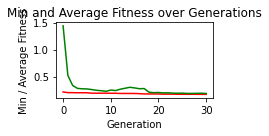

HOF ITEM
0.17125906582344816
-0.4080255589523387,1.0,-0.5809949098427616,-3.4759244296193934,3.998107550012716,-6.232269203407187,7.0,2.2332037757132306,5.459734640296577,-0.022350843912612356,-1.8430907727715824,3.8244620647157284,-0.9411415950515927,2.226822007839292,5.291800213340125,0.3303924652628362,3.0,-0.5910669496355915
HOF ITEM
0.17137358796139412
-0.4080255589523387,1.0,-0.5809949098427616,-4.393634785036257,6.015338945946148,-5.576190559857961,7.0,2.706751379442074,5.190883722346143,0.1810434186319626,-3.0,3.8244620647157284,-0.9411415950515927,2.226822007839292,6.492995667233459,0.3303924652628362,3.0,-0.5910669496355915
HOF ITEM
0.17162048821810374
-0.4080255589523387,1.0,0.4589575162231816,-3.4759244296193934,3.998107550012716,-3.7363628813276835,5.915520605273439,2.2332037757132306,5.332376571435048,-4.747630377863784,0.3698842637740982,-2.5105092184816673,-1.0824475861338871,1.7739969958415824,6.492995667233459,0.3303924652628362,3.0,-0.5910669496355915
seed 19
Initial

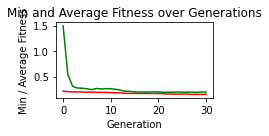

HOF ITEM
0.15080979227571484
0.7842230149200373,0.48021551176679234,3.5931813592655644,-2.9120881826337657,-0.38142533063521045,0.2571445257471472,3.754900363563744,-0.6064336347198944,-6.842930579661382,4.780508672849567,-1.8362658022957385,4.381796501127113,4.915208492861525,0.5797454597942625,6.94720714032114,0.7306681102924226,3.0,-1.5017638811810805
HOF ITEM
0.15266248752405762
0.7842230149200373,0.48021551176679234,3.5931813592655644,-2.9120881826337657,-0.38142533063521045,0.2571445257471472,3.754900363563744,-0.6064336347198944,-7.0,5.204001124555624,-1.8362658022957385,2.8266535797770103,5.28447328129175,0.5166505043656892,6.94720714032114,0.7306681102924226,3.0,-1.5017638811810805
HOF ITEM
0.15281494752331473
0.7842230149200373,0.48021551176679234,3.5931813592655644,-3.4446156821758667,-0.38142533063521045,0.2571445257471472,5.015033263751631,-0.6064336347198944,-6.842930579661382,4.780508672849567,-1.8362658022957385,2.596009539332303,5.012990404259727,0.5797454597942625,6.9

In [19]:
outfolder="2024_12_13_Sp1fit_3afcat_allrates"
rates_affected=[0,1,2,3]
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)
# Genetic Algorithm parameters:
POPULATION_SIZE = 500 #500
MAX_GENERATIONS = 30

MUTSIGMA=1 #sigma
INDPB=0.25

P_CROSSOVER = 0.25  # probability for crossover
P_MUTATION = 0.25  # probability for mutating an individ

S_max=get_S_max(TF,pwmpath=os.path.join(repobase,"PWMs"))    
coop=False

nconditions=len(inputs_outputs) #just one cell type


parsetnames,idxs=get_parsetnames(rates_affected=rates_affected,nconditions=len(inputs_outputs))
parsetnames=parsetnames[:-1] #remove the last one, which is the concentration


idx1,idx2,idx3,idxs_conditions=idxs #we will not use idxs_conditions here
MINV_7=-7
MAXV_7=7
MINV_3=-3 #20
MAXV_3=3 #0.05

#get bounds
bounds=[]
for name in parsetnames:
    if name=="lambda_K":
        bounds.append([-1,1])
    elif name.startswith("n"):
        bounds.append([MINV_3,MAXV_3])
    else:
        bounds.append([MINV_7,MAXV_7])
print("bounds:",bounds)
for x in zip(parsetnames,bounds):
    print(x)

args_fitnessfunction={"logfcfunction":logfoldchange_from_avbinding_ratesdirectly_Hill,"fifunctions":fifunctions,
                      "evaluate_parset":evaluate_parset_function,
      "idx1":idx1, "idx2":idx2, "idx3":idx3,"S_max":S_max,"coop":coop,"rates_affected":rates_affected,
      "inputs_outputs":inputs_outputs,"idxs_conditions":None,"nconditions":nconditions,
     "outerror":"inverse"}
error_partial=partial(error_parset_avbinding_celltypedifbyx,**args_fitnessfunction)
def fitnessfunc(pars):
    return error_partial(pars),

plotbestpartial=None #partial(plot_best,args_fitnessfunction=args_fitnessfunction)

pars_genetic={"POPULATION_SIZE":POPULATION_SIZE, "MAX_GENERATIONS": MAX_GENERATIONS, 
              "P_CROSSOVER": P_CROSSOVER,"P_MUTATION": P_MUTATION, "MUTSIGMA": MUTSIGMA, "INDPB": INDPB,
              "HALL_OF_FAME_SIZE": 3,
             "fitnessfunc": fitnessfunc,
             "seeds":np.arange(20),
              "plot_fitness_evo":True, 
              "plotintermediates":False, 
              "plotbest":False, "plotbestfunc":plotbestpartial, "bounds":bounds}

best=run_genetic(**pars_genetic)
print("best")
print(best)
fitness,parset,seed,refined=best
best_condition={"jid":jid,"celltype":celltype,"affinitygrouping":affinitygrouping,"seed":int(seed),"fitness":fitness,"parset":",".join(list(map(str,parset))),"refined":refined}
with open("./%s/best_%d.json"%(outfolder,jid), "w") as outfile: 
    json.dump(best_condition, outfile)

1.00 ['1.00']
0.75 ['0.75']
0.10 ['0.10']


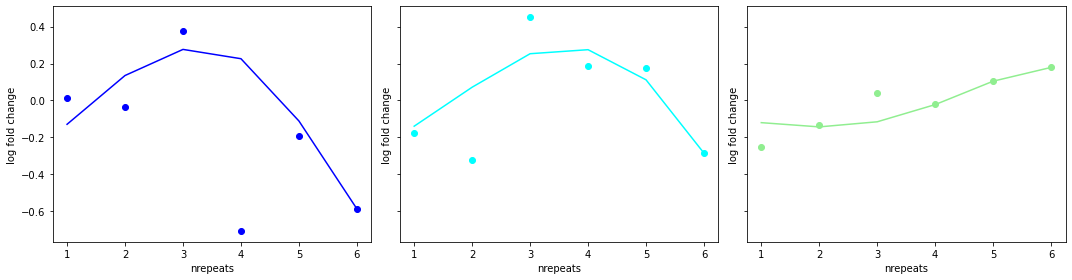

In [20]:
plot_best(parset,args_fitnessfunction,afcats=affinities_tofit)

bounds: [[-7, 7], [-1, 1], [-7, 7], [-7, 7], [-7, 7], [-7, 7], [-7, 7], [-3, 3], [0, 7], [-7, 7], [-3, 3], [-7, 0], [-7, 7], [-3, 3], [0, 7], [-7, 7], [-3, 3], [0, 7]]
('K_max', [-7, 7])
('lambda_K', [-1, 1])
('k_1', [-7, 7])
('k_m1', [-7, 7])
('k_2', [-7, 7])
('k_3', [-7, 7])
('K_r0', [-7, 7])
('n_r0', [-3, 3])
('fc_r0', [0, 7])
('K_r1', [-7, 7])
('n_r1', [-3, 3])
('fc_r1', [-7, 0])
('K_r2', [-7, 7])
('n_r2', [-3, 3])
('fc_r2', [0, 7])
('K_r3', [-7, 7])
('n_r3', [-3, 3])
('fc_r3', [0, 7])
seed 0
Initial fitness values: [0.23565525984362326, 0.23565516278443085, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356, 0.23565516278441356]
Final fitness values: [0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342, 0.23565516278441342]


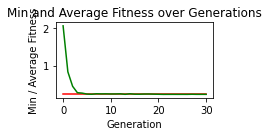

HOF ITEM
0.23565516278441342
-6.192769872215016,-1.0,-0.9762218573366186,2.820095626857019,-2.1564523915090685,-5.525382055735718,6.607113191400371,1.4417427663100941,1.1520962608666836,4.207120113902911,3.0,-5.124894978297601,5.682696195926351,3.0,4.652751063669305,6.247576324701423,1.5463141219142646,4.395049432673823
HOF ITEM
0.23565516278441342
-6.192769872215016,-1.0,-0.9762218573366186,2.861621551616431,-2.1564523915090685,-5.525382055735718,6.607113191400371,2.148660250710379,1.1520962608666836,4.231043177116063,3.0,-0.8883768358847288,4.819538304981757,2.302897700643318,4.652751063669305,6.247576324701423,1.5463141219142646,4.395049432673823
HOF ITEM
0.23565516278441342
-6.192769872215016,-1.0,-0.9762218573366186,2.861621551616431,-2.1564523915090685,-5.525382055735718,6.607113191400371,2.148660250710379,1.1520962608666836,4.231043177116063,3.0,-3.548882020335199,4.817311967420163,3.0,4.652751063669305,6.247576324701423,1.5463141219142646,4.395049432673823
seed 1
Initial fitnes

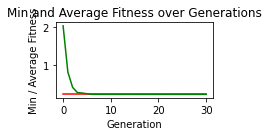

HOF ITEM
0.23565516278441326
-7.0,1.0,-2.106473029275988,-3.5149966273957203,-6.525247123996359,-0.9892129264812268,-6.621279165452945,0.48204631239671514,0.0,2.1176033692616794,-1.8204800724917973,0.0,4.782228871422791,1.6297309883675477,3.219161860717649,1.1392257376380739,1.7015386897662006,2.7782014948764435
HOF ITEM
0.23565516278441326
-7.0,1.0,-2.106473029275988,-3.5149966273957203,-6.525247123996359,-0.9892129264812268,-7.0,0.48204631239671514,0.0,1.6345712883750914,-3.0,0.0,4.4495089436677056,3.0,6.3373244114050955,1.1392257376380739,1.7015386897662006,2.4390174430792424
HOF ITEM
0.23565516278441326
-6.522100234536978,-1.0,-0.21490896716431296,-6.789734269610287,-5.652918422403779,-2.3511099588642823,-5.472632616417961,-0.5198064778962341,0.0,2.705788522973672,1.4300784776076116,0.0,4.088140587008543,2.4684216476755703,6.3373244114050955,-0.018374559308781957,1.9327656211751203,0.24288903514757498
seed 2
Initial fitness values: [0.23565583611268634, 0.2356551629727515, 0.235655

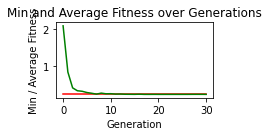

HOF ITEM
0.2356551627844127
-7.0,0.8357839113568815,-6.792166710530271,6.139340088086495,-0.27781861659335066,4.861501317369165,6.2689644610472595,1.3794521742396078,0.22488405871371175,-5.592588414019741,2.2099702972789546,-1.8481175248116037,6.874648460203023,2.342311596132353,4.3639136645321805,6.848462754296887,0.5378047699469923,0.7803139710829377
HOF ITEM
0.2356551627844127
-7.0,0.8357839113568815,-5.83696552989986,7.0,-0.9763767273574684,4.861501317369165,6.2689644610472595,1.3794521742396078,1.4451740707426421,-4.173545673148894,2.5902407548554023,-0.14747208672968057,6.874648460203023,2.342311596132353,4.3639136645321805,6.848462754296887,0.5378047699469923,0.7803139710829377
HOF ITEM
0.2356551627844127
-7.0,0.8357839113568815,-5.83696552989986,7.0,-0.9763767273574684,4.861501317369165,6.2689644610472595,1.3794521742396078,1.4451740707426421,-4.643421282661901,2.5902407548554023,-1.8481175248116037,6.874648460203023,2.342311596132353,4.3639136645321805,6.848462754296887,0.5378

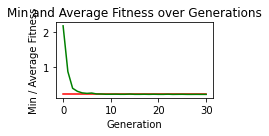

HOF ITEM
0.23565516278441304
-0.0387251924926284,-0.27611131552359436,-4.781349754731423,5.031357242582266,-2.0942674667613455,3.4836284184444155,6.416526297403579,3.0,5.599408583298063,5.519663660722322,2.61067641389985,0.0,6.829370656753066,2.623736223952012,2.4760905073880815,-3.458217132195884,2.7642190604196895,1.5700159549610886
HOF ITEM
0.23565516278441304
-0.0387251924926284,-0.27611131552359436,-4.781349754731423,5.031357242582266,-2.0942674667613455,3.4836284184444155,5.926301501992866,2.6327528071719297,5.599408583298063,5.46621023451546,2.61067641389985,0.0,6.829370656753066,2.4775567269621535,2.4760905073880815,-3.458217132195884,2.7642190604196895,1.5700159549610886
HOF ITEM
0.23565516278441304
-0.0387251924926284,-0.27611131552359436,-5.158689058967678,5.031357242582266,-0.8671291828565733,3.3361615292931193,5.926301501992866,2.6327528071719297,5.599408583298063,5.519663660722322,2.61067641389985,-1.1003876833471113,6.829370656753066,2.4775567269621535,2.4760905073880815

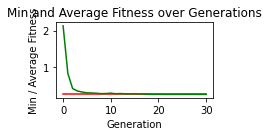

HOF ITEM
0.2356551627844133
-4.885460616331259,-0.8875002057981968,-1.1709599123164933,1.4545959762726302,6.267111043805306,1.7092809910754068,2.4750516895110235,2.499971362970525,4.356452931493082,1.2309522565670838,2.5943641220583533,-6.838679525774321,4.43278879976014,2.2650525815004583,5.231088548117606,2.7019197504265473,1.8604842674140416,3.6426227374981273
HOF ITEM
0.2356551627844133
-4.885460616331259,-0.8753989938691311,-0.775611804562627,1.2391020214776647,6.267111043805306,1.7092809910754068,2.148806575833648,2.499971362970525,3.526717611092274,-0.015807111178668842,2.491591029277739,-6.536639121172224,1.1542050836278002,2.2650525815004583,7.0,3.0150648921395575,1.8604842674140416,5.706886954232004
HOF ITEM
0.2356551627844133
-4.885460616331259,-0.8875002057981968,-1.1709599123164933,1.4545959762726302,6.267111043805306,1.7092809910754068,2.4750516895110235,2.499971362970525,3.526717611092274,-0.015807111178668842,2.5943641220583533,-6.838679525774321,4.43278879976014,2.2650

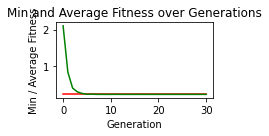

HOF ITEM
0.2356551627844129
-6.836863364803572,0.7529105254750537,6.434794371474233,-6.594952827705308,-2.750437206667522,5.0901981179155396,4.102051167224245,1.8159314618259412,0.7607855953495555,-1.590050096402393,2.479305253894908,-4.035477982836504,6.0312343686001135,2.768208456788705,6.733792958751885,6.325566163883244,1.0033286478049463,2.0470759527305282
HOF ITEM
0.2356551627844129
-6.836863364803572,0.7529105254750537,6.434794371474233,-6.594952827705308,-2.750437206667522,5.0901981179155396,3.4858770133571646,1.8159314618259412,2.179156194744136,-1.590050096402393,2.479305253894908,-4.183705561748624,6.0312343686001135,2.768208456788705,6.733792958751885,6.325566163883244,1.0033286478049463,2.0470759527305282
HOF ITEM
0.2356551627844131
-6.836863364803572,0.6613555546803148,6.434794371474233,-5.947613001587007,-3.9675242816416376,5.0901981179155396,3.4858770133571646,1.8159314618259412,0.9520193143793291,-1.8859895663696216,2.479305253894908,-3.966284763086752,6.03123436860011

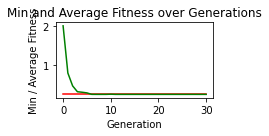

HOF ITEM
0.23565516278441279
-6.723222631661479,0.8543734043161447,-4.9050516487721465,5.900197549756448,-2.636889920313439,-4.387399718349278,5.449097299851081,3.0,7.0,-3.9589234757863063,2.673555393151804,-0.049430385822133105,6.582548557611432,1.7560228106716447,2.435147453248395,4.067175966473949,1.3824929050059342,5.464772571472409
HOF ITEM
0.23565516278441287
-6.723222631661479,-0.13636377368233354,-4.9050516487721465,5.900197549756448,-2.636889920313439,-4.387399718349278,5.449097299851081,2.413121467172365,6.89940293833522,-3.6628470761593954,2.3876961909113055,-0.049430385822133105,5.798617721793075,1.7560228106716447,2.435147453248395,4.067175966473949,1.3824929050059342,5.464772571472409
HOF ITEM
0.23565516278441287
-6.723222631661479,-0.13636377368233354,-4.9050516487721465,5.900197549756448,-2.636889920313439,-4.387399718349278,5.449097299851081,2.643626487664519,5.948068693984971,-3.6628470761593954,2.3876961909113055,-0.049430385822133105,6.582548557611432,1.756022810671

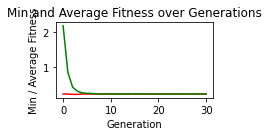

HOF ITEM
0.22556206518907598
6.277552713008241,0.207259639963272,5.922583183833216,-2.5491892097717925,-5.808540557039624,1.7601116188206773,1.5292971208433392,-2.400311257148542,3.220414361718518,-0.5213803632618588,1.2952740415246873,-5.623470533680388,0.8360696574686921,2.9540187537339615,0.1097659271744692,3.087810036000929,0.7600737619146098,0.6237950469261182
HOF ITEM
0.23565516278441223
-6.174522627015953,-0.32178216454215247,-3.3840955269001958,6.161536380796044,-7.0,6.945304266320711,-3.9433709329236453,2.1793892660898964,0.0,4.294395576196109,2.03901447290565,-1.3193376757079651,4.690734069009215,2.8844599720171296,5.984664832279436,6.744574711695006,0.6205397625477063,2.996821804580234
HOF ITEM
0.23565516278441223
-6.174522627015953,-0.32178216454215247,-3.3840955269001958,6.161536380796044,-7.0,6.945304266320711,-3.9433709329236453,2.1793892660898964,0.0,4.294395576196109,2.03901447290565,-2.2394626488314557,6.3257413545945,2.5853220056380115,5.984664832279436,6.74457471169

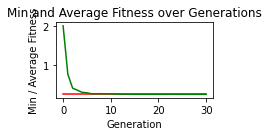

HOF ITEM
0.23565516278441345
-5.804299195479735,-1.0,-0.06846325304357159,-3.5499322762444137,2.103603771624848,0.7349352810188934,3.175214590857265,2.244284966874323,3.932658099095566,3.342220572481419,1.7171019598627564,-3.0368828965048302,3.8940259565848327,-0.38905240666070684,0.0,-2.3658330247239876,2.482214647125732,6.091625264076265
HOF ITEM
0.23565516278441345
-5.804299195479735,-1.0,-0.06846325304357159,-3.5499322762444137,2.103603771624848,0.7349352810188934,3.175214590857265,2.244284966874323,3.932658099095566,3.1711188856260493,1.7171019598627564,-1.3482889057652172,3.265167855934836,-1.7096202693538372,0.0,-2.3658330247239876,2.482214647125732,6.091625264076265
HOF ITEM
0.23565516278441345
-5.427285628281796,-1.0,-0.06846325304357159,-1.3908824526385222,2.103603771624848,0.6323125198346113,3.175214590857265,2.244284966874323,3.1858396499697124,2.9367085196462144,1.7171019598627564,-1.530044346899639,7.0,-0.38905240666070684,0.0,-1.7834050903837355,3.0,7.0
seed 9
Initial fi

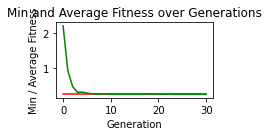

HOF ITEM
0.23565516278441276
-5.743840074062861,0.5348615676397226,6.392036171968221,-6.5522695045059836,-2.088063406285327,4.144108814443017,6.637965413837333,1.2322470295945216,5.401873173101309,-3.9999271764730246,-2.533697941510343,0.0,-1.2512999379677219,3.0,0.3932851966245254,5.091851314098464,2.756015356729652,7.0
HOF ITEM
0.23565516278441276
-5.743840074062861,0.5348615676397226,6.392036171968221,-6.5522695045059836,-2.088063406285327,4.144108814443017,6.637965413837333,1.2322470295945216,5.401873173101309,-3.9999271764730246,-3.0,0.0,-1.2512999379677219,3.0,0.08166048459619618,3.1024575777110983,3.0,7.0
HOF ITEM
0.23565516278441276
-5.743840074062861,0.5348615676397226,6.392036171968221,-6.5522695045059836,-2.088063406285327,4.144108814443017,6.637965413837333,1.2322470295945216,5.401873173101309,-3.9999271764730246,-2.533697941510343,0.0,-1.2512999379677219,2.63373226360195,0.08166048459619618,3.1024575777110983,3.0,7.0
seed 10
Initial fitness values: [0.2356557225656987, 0.2

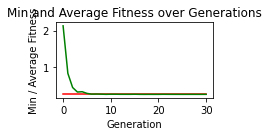

HOF ITEM
0.23565516278441315
-4.571485469504184,-0.324861909755761,3.4750376997815575,-1.0336586171781064,1.3427421414021674,4.996323420584182,-2.4455645594822784,2.894686598724351,1.3444629836970723,-6.8898504328643595,2.568361954317512,-2.3446649847962515,-0.6353239409961275,2.9254692315787754,6.207352152369904,4.620007124818407,1.6453467371722355,7.0
HOF ITEM
0.23565516278441315
-4.571485469504184,1.0,3.4750376997815575,-1.0336586171781064,1.3427421414021674,4.996323420584182,-2.4455645594822784,2.894686598724351,1.3444629836970723,-6.8898504328643595,2.744576139534434,-2.031474661398475,1.6766167444627678,2.9254692315787754,6.207352152369904,4.620007124818407,1.6453467371722355,7.0
HOF ITEM
0.2356551627844132
-4.901190332372491,-0.324861909755761,3.4750376997815575,-1.0336586171781064,1.3427421414021674,4.996323420584182,-2.4455645594822784,2.894686598724351,1.3444629836970723,-7.0,2.565696117664047,-4.51007097346156,1.2410380439091615,2.4954014046295243,6.9543262453577235,4.620007

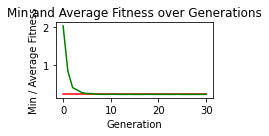

HOF ITEM
0.235655162784413
-5.001299976587516,1.0,-1.7170983764522045,7.0,5.455623364342447,5.582573638762068,6.658314511485556,3.0,0.7328571047300805,3.5081525770627158,2.4916781542268938,-4.692879471655121,7.0,2.7792222644859796,0.6762582685608354,0.40625919152855827,2.247039995436511,3.9862655838875405
HOF ITEM
0.235655162784413
-5.001299976587516,-0.12763611042958645,-1.7548639999352154,7.0,5.787006910621539,5.582573638762068,6.658314511485556,3.0,0.0,4.7953138332383745,2.4916781542268938,-4.692879471655121,5.703114747162019,1.4576551482152178,0.7494802557370732,0.40625919152855827,2.247039995436511,4.213592626665809
HOF ITEM
0.235655162784413
-5.001299976587516,1.0,-1.7170983764522045,5.893459716802205,5.455623364342447,5.582573638762068,6.658314511485556,3.0,0.0,2.880112359417134,2.4916781542268938,-5.1278742985857395,5.703114747162019,2.8982439850859185,0.7494802557370732,0.40625919152855827,2.247039995436511,4.1720123262588045
seed 12
Initial fitness values: [0.2356551627844135

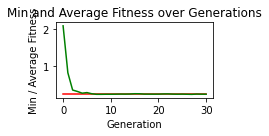

HOF ITEM
0.23565516278441342
-7.0,-0.16980299982033353,-0.7522292084136695,3.6409067642054,1.7845726747861623,0.4855341159464581,5.846372243998292,2.6403860963680583,5.730571967915267,5.967673637367975,2.3217901774665153,-2.789782847589046,-4.241727838592043,2.6685866939286904,4.298267550533057,-0.7173410233460931,2.905884472066819,1.425764126921777
HOF ITEM
0.23565516278441342
-7.0,-0.16980299982033353,-0.7522292084136695,3.6409067642054,1.7845726747861623,0.4855341159464581,5.846372243998292,2.6403860963680583,5.730571967915267,5.967673637367975,3.0,-1.5089278392651637,-4.241727838592043,2.6685866939286904,4.298267550533057,-0.7173410233460931,2.905884472066819,1.425764126921777
HOF ITEM
0.23565516278441342
-6.57167368797713,-0.16980299982033353,-0.7522292084136695,3.6409067642054,1.7845726747861623,0.4855341159464581,5.846372243998292,2.6403860963680583,5.730571967915267,7.0,2.5090729667163574,-1.648038149903381,-4.241727838592043,2.6685866939286904,4.298267550533057,-0.717341023346

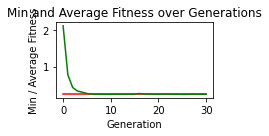

HOF ITEM
0.23565516278441279
-7.0,0.6713539883479491,6.646093085899616,7.0,-2.093050794353491,5.965096786706174,0.306546514866487,3.0,2.9666417136556005,-3.5593840176720875,3.0,-7.0,-0.7641464571663343,1.9914560098193843,5.920599147818629,2.577102548897296,1.3988927435697718,2.0571780874056613
HOF ITEM
0.23565516278441287
-6.803326279848898,1.0,3.9673212643278895,7.0,-5.996367132743428,4.60239180350682,1.736053674924373,1.8097635532754095,3.385106087511394,-3.7263844192472297,2.965027522256478,-5.707433610001559,-3.2729150822351305,2.458698944156338,6.072474456279403,2.577102548897296,1.3988927435697718,0.7319490388688642
HOF ITEM
0.23565516278441287
-6.803326279848898,1.0,3.9673212643278895,7.0,-5.996367132743428,4.60239180350682,1.736053674924373,1.8097635532754095,3.385106087511394,-4.413201509841121,2.965027522256478,-5.649040512283294,-1.2643687265965728,2.2201724507157126,5.5145924082248605,2.577102548897296,1.3988927435697718,0.7319490388688642
seed 14
Initial fitness values: [0

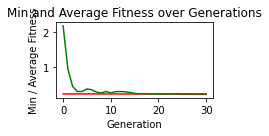

HOF ITEM
0.22326821101185398
4.812373822945912,0.4530809121208035,6.0670460348382145,-5.6893295313589745,-1.0883351509179637,-2.945176358485382,3.648275189520271,2.759272128037498,3.6989005997519624,-5.658600519048868,2.4357900774065877,-4.726741929966025,1.1550559130393405,3.0,6.563508634788528,5.380617355253462,2.2151517586265337,7.0
HOF ITEM
0.22445941413345763
4.812373822945912,0.4530809121208035,3.5160836234841746,-1.434377256066225,0.9772599115740972,-0.57674956355693,1.9620564870696044,2.79979777710444,0.8017081491255545,-0.34589563800004663,2.9383718254325024,-3.040895551647581,1.1550559130393405,3.0,6.563508634788528,5.380617355253462,2.2151517586265337,7.0
HOF ITEM
0.22447273529093212
4.812373822945912,0.4530809121208035,4.314432979975814,-2.3260482673087757,0.9772599115740972,-0.57674956355693,2.0019156175124846,2.79979777710444,1.882977829226987,-0.34589563800004663,2.4357900774065877,-4.535851422292342,1.1550559130393405,3.0,6.563508634788528,5.380617355253462,2.2151517586

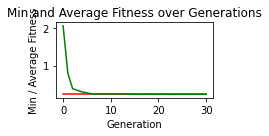

HOF ITEM
0.23565516278441345
-4.20116568616508,1.0,-2.258449332429443,-1.2192773005250197,3.8122812802999375,0.15522590164724215,3.868375135847439,2.950348226318766,1.5952762295501273,5.325168509746669,1.7256103256159587,-4.599040418761742,-0.2758685457696022,2.9516358578636464,0.7098318257296821,4.016278141065523,-1.2856626914423064,0.0
HOF ITEM
0.23565516278441345
-4.20116568616508,1.0,-2.258449332429443,-1.2192773005250197,3.8122812802999375,0.15522590164724215,3.868375135847439,2.950348226318766,1.5952762295501273,5.325168509746669,1.7256103256159587,-4.85116088670491,-0.508973953653737,2.9516358578636464,5.799685885551783,4.548924117587249,-1.2856626914423064,0.0
HOF ITEM
0.23565516278441345
-4.20116568616508,1.0,-2.258449332429443,-1.2192773005250197,3.8122812802999375,0.15522590164724215,3.868375135847439,2.950348226318766,1.5952762295501273,5.325168509746669,1.7256103256159587,-4.599040418761742,-0.2758685457696022,2.9516358578636464,5.799685885551783,4.016278141065523,-1.28566

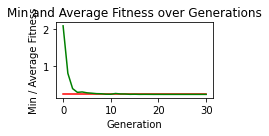

HOF ITEM
0.23565516278441298
-6.2866552510778915,0.8042619871251846,6.635033512726833,-1.5673491380080053,7.0,-3.712504180803273,6.120608439251645,0.9067453008297248,0.7502370959654072,-0.5008092475361028,2.6474412333150465,-3.554385361820173,-3.3210463720934236,3.0,0.0,5.44548666212259,1.716448983493648,0.4023335341336811
HOF ITEM
0.2356551627844131
-6.2866552510778915,0.8042619871251846,7.0,-1.3077823485749258,6.9897334542546234,-3.712504180803273,5.109170675314968,0.9067453008297248,0.7502370959654072,-1.3764758344875818,2.787710203765018,-5.543245200933392,6.949549921374107,2.2925946892080873,0.0,5.987777553080777,1.716448983493648,1.1881496551164354
HOF ITEM
0.2356551627844131
-6.2866552510778915,0.8042619871251846,7.0,-1.5673491380080053,6.9897334542546234,-3.712504180803273,5.109170675314968,0.9067453008297248,0.7502370959654072,-0.5008092475361028,2.787710203765018,-5.543245200933392,6.1253486490807925,2.2925946892080873,0.0,5.987777553080777,1.716448983493648,0.402333534133681

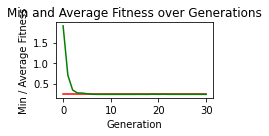

HOF ITEM
0.2356551627844131
-6.250432992884614,0.8754497608504195,3.1932878253691723,6.704956861739969,-4.75346086922815,-0.5330107958069124,-1.2759696012199493,3.0,3.213147543034432,6.435153716980765,2.9922224571305414,-3.8566490058178426,3.2193979799540124,2.871740666778761,0.2758108158798568,5.435192442112896,1.199248127062729,3.427013994480685
HOF ITEM
0.2356551627844131
-6.250432992884614,0.8754497608504195,3.1932878253691723,6.704956861739969,-4.75346086922815,-0.5330107958069124,-1.2759696012199493,3.0,3.213147543034432,6.435153716980765,2.9922224571305414,-3.8566490058178426,0.5410115934285743,3.0,4.872595496109021,5.435192442112896,1.199248127062729,3.427013994480685
HOF ITEM
0.23565516278441315
-7.0,1.0,1.6800950435753594,6.704956861739969,-4.339532162325742,0.4412898396053823,-0.7551560183994741,2.317029471393984,3.2268750553667824,6.435153716980765,2.9922224571305414,-6.194486630447718,0.8187179951313457,3.0,4.872595496109021,5.090704715570549,1.199248127062729,3.4270139944

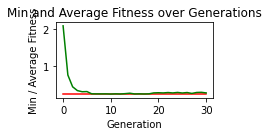

HOF ITEM
0.23565516278441304
-5.9615814256448285,0.1743301496036016,-3.098905957313681,4.633448059852025,-3.382899733501289,2.155871586452922,-3.7681790140162783,2.3888543192033453,6.58640638797935,4.749054006136743,2.5174299270927425,-0.7359623340834592,-0.5141639107464311,2.879801994858263,1.302705502225731,6.991291149132039,1.0111665529120273,4.1562236052031185
HOF ITEM
0.23565516278441304
-5.9615814256448285,0.1743301496036016,-3.098905957313681,4.633448059852025,-3.382899733501289,2.155871586452922,-3.7681790140162783,2.131857410916786,6.58640638797935,4.749054006136743,2.7281549585448834,-0.7359623340834592,-0.5141639107464311,3.0,2.380719930707896,6.991291149132039,1.0111665529120273,4.1562236052031185
HOF ITEM
0.23565516278441304
-5.9615814256448285,0.1743301496036016,-3.098905957313681,4.633448059852025,-3.382899733501289,2.155871586452922,-3.7681790140162783,2.131857410916786,6.58640638797935,4.749054006136743,2.7281549585448834,-0.7359623340834592,-0.5141639107464311,2.87980

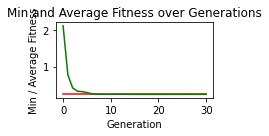

HOF ITEM
0.23565516278441287
-4.989475524050882,1.0,6.410372776041494,1.8183515876607725,4.052944047904912,6.4680893910240425,4.165154490796052,1.6004889938642533,4.547267595394975,0.6393976222818647,2.3387724222663877,-1.635383633145172,7.0,0.18351819356371268,0.0,4.481130575696603,3.0,2.6974331949806043
HOF ITEM
0.23565516278441287
-5.9556661197549845,1.0,6.410372776041494,1.9352233763767306,4.052944047904912,6.4680893910240425,3.8054036151652983,1.5240912304907615,4.547267595394975,0.73497832517285,2.0044741698190003,-1.3588630969878703,5.795356132183546,1.3393266586371222,1.6073314839450341,-1.5385429910390003,3.0,1.9494194173022314
HOF ITEM
0.2356551627844129
-5.516200375332119,1.0,6.410372776041494,1.9352233763767306,4.052944047904912,6.4680893910240425,3.8054036151652983,1.6004889938642533,4.547267595394975,2.132345753341136,2.3387724222663877,-2.257866137707378,6.969658411631203,-2.019536422043342,0.0,3.732502742800821,1.666723172210552,1.1427053023917535
best parameter set
fit

In [22]:
outfolder="2024_12_13_Sp1fit_3afcat_allrates_coherent"
rates_affected=[0,1,2,3]
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)
# Genetic Algorithm parameters:
POPULATION_SIZE = 500 #500
MAX_GENERATIONS = 30

MUTSIGMA=1 #sigma
INDPB=0.25

P_CROSSOVER = 0.25  # probability for crossover
P_MUTATION = 0.25  # probability for mutating an individ

S_max=get_S_max(TF,pwmpath=os.path.join(repobase,"PWMs"))    
coop=False

nconditions=len(inputs_outputs) #just one cell type


parsetnames,idxs=get_parsetnames(rates_affected=rates_affected,nconditions=len(inputs_outputs))
parsetnames=parsetnames[:-1] #remove the last one, which is the concentration


idx1,idx2,idx3,idxs_conditions=idxs #we will not use idxs_conditions here
MINV_7=-7
MAXV_7=7
MINV_3=-3 #20
MAXV_3=3 #0.05

#get bounds
bounds=[]
for name in parsetnames:
    if name=="lambda_K":
        bounds.append([-1,1])
    elif name.startswith("n"):
        bounds.append([MINV_3,MAXV_3])
    elif name.startswith("fc"):
        if name=="fc_r1":
            bounds.append([MINV_7,0])
        else:
            bounds.append([0,MAXV_7])
    else:
        bounds.append([MINV_7,MAXV_7])
print("bounds:",bounds)
for x in zip(parsetnames,bounds):
    print(x)

args_fitnessfunction={"logfcfunction":logfoldchange_from_avbinding_ratesdirectly_Hill,"fifunctions":fifunctions,
                      "evaluate_parset":evaluate_parset_function,
      "idx1":idx1, "idx2":idx2, "idx3":idx3,"S_max":S_max,"coop":coop,"rates_affected":rates_affected,
      "inputs_outputs":inputs_outputs,"idxs_conditions":None,"nconditions":nconditions,
     "outerror":"inverse"}
error_partial=partial(error_parset_avbinding_celltypedifbyx,**args_fitnessfunction)
def fitnessfunc(pars):
    return error_partial(pars),

plotbestpartial=None #partial(plot_best,args_fitnessfunction=args_fitnessfunction)

pars_genetic={"POPULATION_SIZE":POPULATION_SIZE, "MAX_GENERATIONS": MAX_GENERATIONS, 
              "P_CROSSOVER": P_CROSSOVER,"P_MUTATION": P_MUTATION, "MUTSIGMA": MUTSIGMA, "INDPB": INDPB,
              "HALL_OF_FAME_SIZE": 3,
             "fitnessfunc": fitnessfunc,
             "seeds":np.arange(20),
              "plot_fitness_evo":True, 
              "plotintermediates":False, 
              "plotbest":False, "plotbestfunc":plotbestpartial, "bounds":bounds}

best=run_genetic(**pars_genetic)
print("best")
print(best)
fitness,parset,seed,refined=best
best_condition={"jid":jid,"celltype":celltype,"affinitygrouping":affinitygrouping,"seed":int(seed),"fitness":fitness,"parset":",".join(list(map(str,parset))),"refined":refined}
with open("./%s/best_%d.json"%(outfolder,jid), "w") as outfile: 
    json.dump(best_condition, outfile)

1.00 ['1.00']
0.75 ['0.75']
0.10 ['0.10']


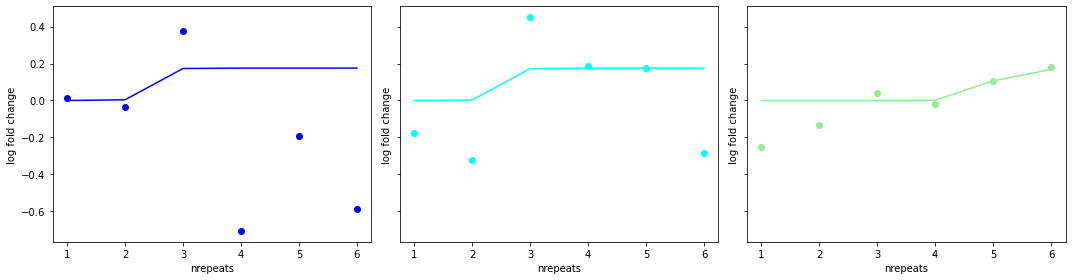

In [23]:
plot_best(parset,args_fitnessfunction,afcats=affinities_tofit)